In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [8]:
rating = pd.read_csv('rating.csv')
rating.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,4/2/2005 23:53
1,1,29,3.5,4/2/2005 23:31
2,1,32,3.5,4/2/2005 23:33
3,1,47,3.5,4/2/2005 23:32
4,1,50,3.5,4/2/2005 23:29


In [9]:
movies = pd.read_csv('movie.csv')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
merge_ratings_movies = pd.merge(movies, rating, on='movieId', how='inner')
merge_ratings_movies.head(5)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,3/13/1997 17:50
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,6/5/1996 13:37
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,11/25/1999 2:44
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,1/2/2009 1:13
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,4.0,3/22/1997 20:48


In [13]:
ratings_grouped_by_movie = merge_ratings_movies.groupby('movieId').agg([np.size, np.mean])
ratings_grouped_by_movie.head(5)

userId              rating          
          size         mean   size      mean
movieId                                     
1           13  1509.538462     13  3.807692
2            4  2347.250000      4  3.125000
3            7   434.285714      7  3.714286
5            5  1371.600000      5  2.900000
6            6  1206.333333      6  3.500000

In [14]:
ratings_grouped_by_movie.columns[[0, 1]]

MultiIndex([('userId', 'size'),
            ('userId', 'mean')],
           )

In [24]:
df = pd.merge(ratings_grouped_by_movie, movies, on="movieId")
df

C:\Users\josna\AppData\Local\Temp/ipykernel_13600/1585744400.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  df = pd.merge(ratings_grouped_by_movie, movies, on="movieId")


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,5,Father of the Bride Part II (1995),Comedy
4,6,Heat (1995),Action|Crime|Thriller
...,...,...,...
493,65261,Ponyo (Gake no ue no Ponyo) (2008),Adventure|Animation|Children|Fantasy
494,66934,Dr. Horrible's Sing-Along Blog (2008),Comedy|Drama|Musical|Sci-Fi
495,69757,(500) Days of Summer (2009),Comedy|Drama|Romance
496,86833,Bridesmaids (2011),Comedy


In [25]:
df.describe()

,movieId
count,498.000000
mean,5213.847390
std,15313.799244
min,1.000000
25%,253.750000
50%,785.500000
75%,2268.750000
max,87192.000000


In [26]:
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 497
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  498 non-null    int64 
 1   title    498 non-null    object
 2   genres   498 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.6+ KB


In [29]:
df_maindata = pd.read_csv('maindataset.csv')

In [31]:
df_maindata.head(5)

,movieId,"('rating', 'size')","('rating', 'mean')",title,genres,language
0,1,49695,3.921240,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,en
1,2,22243,3.211977,Jumanji (1995),Adventure|Children|Fantasy,en
2,3,12735,3.151040,Grumpier Old Men (1995),Comedy|Romance,en
3,4,2756,2.861393,Waiting to Exhale (1995),Comedy|Drama|Romance,en
4,5,12161,3.064592,Father of the Bride Part II (1995),Comedy,en


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    V = vectorizer.fit_transform(text)
    return V

In [39]:
text = df['genres'].values
V = vectorize(text, 2 ** 12)
V.shape

(15443, 21)

In [40]:
#converting the sparse matrix to dataframe to be able to merge with df

V = pd.DataFrame.sparse.from_spmatrix(V)

In [41]:
V

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.420501,0.529229,0.502055,0.220675,0.0,0.0,0.00000,0.492280,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.513257,0.000000,0.612801,0.000000,0.0,0.0,0.00000,0.600869,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.501332,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.865255,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.419291,0.0,0.0,0.54819,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.723660,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15439,0.0,0.000000,0.000000,0.000000,0.495158,0.0,0.0,0.00000,0.000000,0.0,...,0.868803,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15440,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15441,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [42]:
df.iloc[0]

movieId                                                         1
('rating', 'size')                                          49695
('rating', 'mean')                                        3.92124
title                                            Toy Story (1995)
genres                Adventure|Animation|Children|Comedy|Fantasy
language                                                       en
Name: 0, dtype: object

In [43]:
df

,movieId,"('rating', 'size')","('rating', 'mean')",title,genres,language
0,1,49695,3.921240,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,en
1,2,22243,3.211977,Jumanji (1995),Adventure|Children|Fantasy,en
2,3,12735,3.151040,Grumpier Old Men (1995),Comedy|Romance,en
3,4,2756,2.861393,Waiting to Exhale (1995),Comedy|Drama|Romance,en
4,5,12161,3.064592,Father of the Bride Part II (1995),Comedy,en
...,...,...,...,...,...,...
15438,131250,1,4.000000,No More School (2000),Comedy,en
15439,131252,1,4.000000,Forklift Driver Klaus: The First Day on the Jo...,Comedy|Horror,en
15440,131254,1,4.000000,Kein Bund für's Leben (2007),Comedy,en
15441,131256,1,4.000000,"Feuer, Eis & Dosenbier (2002)",Comedy,en


In [44]:
preprocessed_df = pd.merge(df, V,how='inner', left_index=True, right_index=True)
#preprocessed_df = df.join(V, how='inner')

In [45]:
preprocessed_df

,movieId,"('rating', 'size')","('rating', 'mean')",title,genres,language,0,1,2,3,...,11,12,13,14,15,16,17,18,19,20
0,1,49695,3.921240,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,en,0.0,0.420501,0.529229,0.502055,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2,22243,3.211977,Jumanji (1995),Adventure|Children|Fantasy,en,0.0,0.513257,0.000000,0.612801,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,12735,3.151040,Grumpier Old Men (1995),Comedy|Romance,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.865255,0.0,0.0,0.0,0.0
3,4,2756,2.861393,Waiting to Exhale (1995),Comedy|Drama|Romance,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.723660,0.0,0.0,0.0,0.0
4,5,12161,3.064592,Father of the Bride Part II (1995),Comedy,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,131250,1,4.000000,No More School (2000),Comedy,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15439,131252,1,4.000000,Forklift Driver Klaus: The First Day on the Jo...,Comedy|Horror,en,0.0,0.000000,0.000000,0.000000,...,0.868803,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15440,131254,1,4.000000,Kein Bund für's Leben (2007),Comedy,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15441,131256,1,4.000000,"Feuer, Eis & Dosenbier (2002)",Comedy,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [46]:
preprocessed_df.iloc[:,:]

,movieId,"('rating', 'size')","('rating', 'mean')",title,genres,language,0,1,2,3,...,11,12,13,14,15,16,17,18,19,20
0,1,49695,3.921240,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,en,0.0,0.420501,0.529229,0.502055,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2,22243,3.211977,Jumanji (1995),Adventure|Children|Fantasy,en,0.0,0.513257,0.000000,0.612801,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,12735,3.151040,Grumpier Old Men (1995),Comedy|Romance,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.865255,0.0,0.0,0.0,0.0
3,4,2756,2.861393,Waiting to Exhale (1995),Comedy|Drama|Romance,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.723660,0.0,0.0,0.0,0.0
4,5,12161,3.064592,Father of the Bride Part II (1995),Comedy,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,131250,1,4.000000,No More School (2000),Comedy,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15439,131252,1,4.000000,Forklift Driver Klaus: The First Day on the Jo...,Comedy|Horror,en,0.0,0.000000,0.000000,0.000000,...,0.868803,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15440,131254,1,4.000000,Kein Bund für's Leben (2007),Comedy,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15441,131256,1,4.000000,"Feuer, Eis & Dosenbier (2002)",Comedy,en,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [47]:
#dropping title and language
df2 = preprocessed_df.drop(preprocessed_df.columns[[3, 5]], axis=1)
df2

,movieId,"('rating', 'size')","('rating', 'mean')",genres,0,1,2,3,4,5,...,11,12,13,14,15,16,17,18,19,20
0,1,49695,3.921240,Adventure|Animation|Children|Comedy|Fantasy,0.0,0.420501,0.529229,0.502055,0.220675,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2,22243,3.211977,Adventure|Children|Fantasy,0.0,0.513257,0.000000,0.612801,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,12735,3.151040,Comedy|Romance,0.0,0.000000,0.000000,0.000000,0.501332,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.865255,0.0,0.0,0.0,0.0
3,4,2756,2.861393,Comedy|Drama|Romance,0.0,0.000000,0.000000,0.000000,0.419291,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.723660,0.0,0.0,0.0,0.0
4,5,12161,3.064592,Comedy,0.0,0.000000,0.000000,0.000000,1.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,131250,1,4.000000,Comedy,0.0,0.000000,0.000000,0.000000,1.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15439,131252,1,4.000000,Comedy|Horror,0.0,0.000000,0.000000,0.000000,0.495158,0.0,...,0.868803,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15440,131254,1,4.000000,Comedy,0.0,0.000000,0.000000,0.000000,1.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15441,131256,1,4.000000,Comedy,0.0,0.000000,0.000000,0.000000,1.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [48]:
#dropping genre 
df2 = df2.drop(df2.columns[3], axis=1)
df2.iloc[:, 1:]

,"('rating', 'size')","('rating', 'mean')",0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
0,49695,3.921240,0.0,0.420501,0.529229,0.502055,0.220675,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,22243,3.211977,0.0,0.513257,0.000000,0.612801,0.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,12735,3.151040,0.0,0.000000,0.000000,0.000000,0.501332,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.865255,0.0,0.0,0.0,0.0
3,2756,2.861393,0.0,0.000000,0.000000,0.000000,0.419291,0.0,0.0,0.54819,...,0.000000,0.0,0.0,0.0,0.0,0.723660,0.0,0.0,0.0,0.0
4,12161,3.064592,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15439,1,4.000000,0.0,0.000000,0.000000,0.000000,0.495158,0.0,0.0,0.00000,...,0.868803,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15440,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15441,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [49]:
X = df2
X

,movieId,"('rating', 'size')","('rating', 'mean')",0,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,19,20
0,1,49695,3.921240,0.0,0.420501,0.529229,0.502055,0.220675,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2,22243,3.211977,0.0,0.513257,0.000000,0.612801,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,12735,3.151040,0.0,0.000000,0.000000,0.000000,0.501332,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.865255,0.0,0.0,0.0,0.0
3,4,2756,2.861393,0.0,0.000000,0.000000,0.000000,0.419291,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.723660,0.0,0.0,0.0,0.0
4,5,12161,3.064592,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,131250,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15439,131252,1,4.000000,0.0,0.000000,0.000000,0.000000,0.495158,0.0,0.0,...,0.868803,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15440,131254,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15441,131256,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [50]:
#K-means clustering as baseline

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [51]:
# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
   # k_means = KMeans(n_clusters=k, random_state=42).fit(X)
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(X)
    distortions.append(sum(np.min(cdist(X, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\s

C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


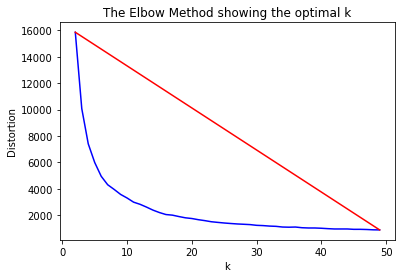

In [52]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [53]:
kmeans = KMeans(n_clusters=10, random_state=42)
y_pred = kmeans.fit_predict(X)
df2['y'] = y_pred

C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [54]:
df2

,movieId,"('rating', 'size')","('rating', 'mean')",0,1,2,3,4,5,6,...,12,13,14,15,16,17,18,19,20,y
0,1,49695,3.921240,0.0,0.420501,0.529229,0.502055,0.220675,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7
1,2,22243,3.211977,0.0,0.513257,0.000000,0.612801,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7
2,3,12735,3.151040,0.0,0.000000,0.000000,0.000000,0.501332,0.0,0.0,...,0.0,0.0,0.0,0.0,0.865255,0.0,0.0,0.0,0.0,7
3,4,2756,2.861393,0.0,0.000000,0.000000,0.000000,0.419291,0.0,0.0,...,0.0,0.0,0.0,0.0,0.723660,0.0,0.0,0.0,0.0,0
4,5,12161,3.064592,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,131250,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,8
15439,131252,1,4.000000,0.0,0.000000,0.000000,0.000000,0.495158,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,8
15440,131254,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,8
15441,131256,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,8


In [55]:
df3 = df2.iloc[0:100,:]
df3

,movieId,"('rating', 'size')","('rating', 'mean')",0,1,2,3,4,5,6,...,12,13,14,15,16,17,18,19,20,y
0,1,49695,3.921240,0.000000,0.420501,0.529229,0.502055,0.220675,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7
1,2,22243,3.211977,0.000000,0.513257,0.000000,0.612801,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7
2,3,12735,3.151040,0.000000,0.000000,0.000000,0.000000,0.501332,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.865255,0.000000,0.000000,0.000000,0.00000,7
3,4,2756,2.861393,0.000000,0.000000,0.000000,0.000000,0.419291,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.723660,0.000000,0.000000,0.000000,0.00000,0
4,5,12161,3.064592,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,159,2366,3.416948,0.000000,0.000000,0.000000,0.000000,0.000000,0.591990,0.0,...,0.0,0.0,0.685976,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0
96,160,14965,2.604744,0.344611,0.429327,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.477628,0.000000,0.000000,0.484145,0.000000,0.000000,0.00000,7
97,161,23628,3.744202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.473334,0.780376,0.00000,7
98,163,14321,3.445395,0.407543,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.459872,0.000000,0.000000,0.000000,0.78894,7


In [57]:
X["movieId"]

0             1
1             2
2             3
3             4
4             5
          ...  
15438    131250
15439    131252
15440    131254
15441    131256
15442    131262
Name: movieId, Length: 15443, dtype: int64

In [58]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, y_pred)

C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [59]:
print(score)

0.6224713974843078


In [60]:
kmeans = KMeans(n_clusters=12, random_state=42)
y_pred = kmeans.fit_predict(X)
df2['y'] = y_pred
score = silhouette_score(X, y_pred)
print(score)

C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\josna\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.5908274684746077


In [61]:
# get a random user ID:
userdf = rating["userId"]
random_user = userdf.sample()
print(random_user)

614    353
Name: userId, dtype: int64


In [64]:
df_rateing_random_user = rating[(rating["userId"] == 353)]
print(df_rateing_random_user)

     userId  movieId  rating        timestamp
598     353      541     5.0  5/17/2001 18:44
599     353      608     5.0  5/17/2001 18:45
600     353      720     5.0  5/17/2001 18:43
601     353      745     5.0  5/17/2001 18:41
602     353      912     4.0  5/17/2001 18:38
603     353      919     5.0  5/17/2001 18:45
604     353      923     5.0  5/17/2001 18:42
605     353      926     5.0  5/17/2001 18:44
606     353     1028     4.0  5/17/2001 18:37
607     353     1032     5.0  5/17/2001 18:38
608     353     1041     3.0  5/17/2001 18:43
609     353     1080     5.0  5/17/2001 18:45
610     353     1148     5.0  5/17/2001 18:41
611     353     1204     5.0  5/17/2001 18:42
612     353     1207     4.0  5/17/2001 18:45
613     353     1210     4.0  5/17/2001 18:37
614     353     1214     4.0  5/17/2001 18:47
615     353     1348     4.0  5/17/2001 18:44
616     353     1394     5.0  5/17/2001 18:46
617     353     1537     4.0  5/17/2001 18:46
618     353     1544     2.0  5/17

In [65]:
df_megered = df_rateing_random_user.merge(X, on='movieId')
df_megered

,userId,movieId,rating,timestamp,"('rating', 'size')","('rating', 'mean')",0,1,2,3,...,12,13,14,15,16,17,18,19,20,y
0,353,541,5.0,5/17/2001 18:44,30526,4.133706,0.410722,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.577024,0.406686,0.000000,0.0,8
1,353,608,5.0,5/17/2001 18:45,43272,4.112359,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.524114,0.000000,0.0,8
2,353,720,5.0,5/17/2001 18:43,8171,4.109473,0.000000,0.591375,0.744285,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,10
3,353,745,5.0,5/17/2001 18:41,12073,4.167315,0.000000,0.000000,0.694409,0.658754,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,10
4,353,919,5.0,5/17/2001 18:45,23445,3.981681,0.000000,0.428766,0.000000,0.511923,...,0.0,0.549668,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,8
5,353,1028,4.0,5/17/2001 18:37,14096,3.732406,0.000000,0.000000,0.000000,0.549855,...,0.0,0.590396,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,10
6,353,1032,5.0,5/17/2001 18:38,7842,3.630133,0.000000,0.377332,0.474897,0.450514,...,0.0,0.483731,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,10
7,353,1080,5.0,5/17/2001 18:45,20557,3.981126,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,10
8,353,1148,5.0,5/17/2001 18:41,15022,4.181068,0.000000,0.000000,0.613632,0.582125,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,10
9,353,1204,5.0,5/17/2001 18:42,12378,4.162102,0.000000,0.560086,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.733912,0.0,10


In [66]:
df_megered = df_megered.drop(df_megered.iloc[:,3:27 ], axis=1)
df_megered

,userId,movieId,rating,y
0,353,541,5.0,8
1,353,608,5.0,8
2,353,720,5.0,10
3,353,745,5.0,10
4,353,919,5.0,8
5,353,1028,4.0,10
6,353,1032,5.0,10
7,353,1080,5.0,10
8,353,1148,5.0,10
9,353,1204,5.0,10


In [67]:
print(X.iloc[1][1])

0.5132565945913001


In [68]:
faveMoviesCluster = []
for i in range(len(df_megered)):
    if(df_megered.iloc[i][2]>=3.0):
        #print(df_megered.iloc[i][0],df_megered.iloc[i][1])
        if(df.iloc[i][1]==11.0):
            break
    faveMoviesCluster.append(df_megered.iloc[i][3])
print(faveMoviesCluster)

[8.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, 10.0, 8.0, 8.0, 0.0, 10.0, 0.0, 10.0, 8.0, 0.0, 10.0, 0.0, 8.0, 10.0, 8.0, 0.0]


In [69]:
res = []
for i in faveMoviesCluster :
    if i not in res:
        res.append(i)
res

[8.0, 10.0, 0.0]

In [70]:
#Not recommended movies

#Sampling from the movies that should not be recommended based on our recommender system
 #X_notFave= X.drop(X.columns[[0, 1]], axis=1)
X

,movieId,"('rating', 'size')","('rating', 'mean')",0,1,2,3,4,5,6,...,12,13,14,15,16,17,18,19,20,y
0,1,49695,3.921240,0.0,0.420501,0.529229,0.502055,0.220675,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,8
1,2,22243,3.211977,0.0,0.513257,0.000000,0.612801,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,8
2,3,12735,3.151040,0.0,0.000000,0.000000,0.000000,0.501332,0.0,0.0,...,0.0,0.0,0.0,0.0,0.865255,0.0,0.0,0.0,0.0,10
3,4,2756,2.861393,0.0,0.000000,0.000000,0.000000,0.419291,0.0,0.0,...,0.0,0.0,0.0,0.0,0.723660,0.0,0.0,0.0,0.0,0
4,5,12161,3.064592,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,131250,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,9
15439,131252,1,4.000000,0.0,0.000000,0.000000,0.000000,0.495158,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,9
15440,131254,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,9
15441,131256,1,4.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,9


In [71]:
X["y"][1]

8

In [72]:
res[0]

8.0

In [73]:
df_megered["movieId"]

0      541
1      608
2      720
3      745
4      919
5     1028
6     1032
7     1080
8     1148
9     1204
10    1210
11    1214
12    1348
13    1394
14    1537
15    1544
16    1617
17    2361
18    2804
19    3022
20    3578
21    3751
22    3793
23    3851
Name: movieId, dtype: int64

In [74]:
movieRecommend = []
for i in range(1,15443,1):
  for ii in range(0,len(res)):
    for iii in range(0,len(df_megered["movieId"])):
      if X["y"][i]== res[ii] and X["movieId"][i] != df_megered["movieId"][iii]:
        movieRecommend.append(X["movieId"][i])
      #print(X["movieId"][i])

In [75]:
resmovieRecommend = []
for i in movieRecommend :
    if i not in resmovieRecommend:
        resmovieRecommend.append(i)
resmovieRecommend

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 18,
 19,
 20,
 21,
 22,
 23,
 29,
 32,
 37,
 38,
 39,
 42,
 44,
 45,
 47,
 48,
 50,
 51,
 52,
 54,
 56,
 58,
 60,
 63,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 75,
 76,
 78,
 82,
 84,
 86,
 87,
 88,
 89,
 92,
 93,
 94,
 95,
 96,
 98,
 101,
 102,
 103,
 104,
 106,
 107,
 109,
 110,
 111,
 112,
 115,
 118,
 119,
 120,
 122,
 123,
 125,
 126,
 129,
 132,
 133,
 135,
 139,
 141,
 144,
 145,
 146,
 149,
 151,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 163,
 164,
 165,
 166,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 176,
 177,
 178,
 180,
 181,
 183,
 185,
 186,
 187,
 188,
 189,
 190,
 194,
 195,
 196,
 198,
 200,
 203,
 204,
 205,
 208,
 212,
 216,
 218,
 220,
 223,
 224,
 226,
 227,
 228,
 231,
 232,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 243,
 244,
 248,
 250,
 251,
 252,
 255,
 256,
 257,
 258,
 259,
 260,
 266,
 267,
 272,
 274,
 275,
 276,
 278,
 281,
 284,
 286,
 287,
 288,
 289,
 292,
 293,
 294,
 295,
 296,
 303,


In [76]:
movieDontRecommend = []
for i in range(1,15443,1):
  for ii in range(0,len(res)):
    if X["y"][i] != res[ii]:
      movieDontRecommend.append(X["movieId"][i])
      #print(X["movieId"][i])

In [77]:
resmovieDONTRecommend = []
for i in movieDontRecommend :
    if i not in resmovieDONTRecommend:
        resmovieDONTRecommend.append(i)
resmovieDONTRecommend

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 18,
 19,
 20,
 21,
 22,
 23,
 29,
 32,
 37,
 38,
 39,
 42,
 44,
 45,
 47,
 48,
 50,
 51,
 52,
 54,
 56,
 58,
 60,
 63,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 75,
 76,
 78,
 82,
 84,
 86,
 87,
 88,
 89,
 92,
 93,
 94,
 95,
 96,
 98,
 101,
 102,
 103,
 104,
 106,
 107,
 109,
 110,
 111,
 112,
 115,
 118,
 119,
 120,
 122,
 123,
 125,
 126,
 129,
 132,
 133,
 135,
 139,
 141,
 144,
 145,
 146,
 149,
 151,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 163,
 164,
 165,
 166,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 176,
 177,
 178,
 180,
 181,
 183,
 185,
 186,
 187,
 188,
 189,
 190,
 194,
 195,
 196,
 198,
 200,
 203,
 204,
 205,
 208,
 212,
 216,
 218,
 220,
 223,
 224,
 226,
 227,
 228,
 231,
 232,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 243,
 244,
 248,
 250,
 251,
 252,
 255,
 256,
 257,
 258,
 259,
 260,
 266,
 267,
 272,
 274,
 275,
 276,
 278,
 281,
 284,
 286,
 287,
 288,
 289,
 292,
 293,
 294,
 295,
 296,
 303,


In [78]:
import random
cluster = []

watched_movies = []
for i in range(len(df_megered)):
  watched_movies.append(int(df_megered.iloc[i][1]))
# print(watched_movies)
# print(X)
sample_items = []
for i in range(len(X)):
  if(X["y"][i] in res and X["movieId"][i] not in watched_movies):
    cluster.append(X["movieId"][i])
sample_items.append(cluster[random.randint(0,len(cluster)-1)])
sample_items.append(cluster[random.randint(0,len(cluster)-1)])
sample_items.append(cluster[random.randint(0,len(cluster)-1)])
    
print(sample_items)

[5321, 1136, 1972]


In [79]:
sample_recommended = sample_items 

In [80]:
import random
movieDontRecommend = []
for i in range(1,15443,1):
  for ii in range(0,len(res)):
    if X["y"][i] != res[ii]:
      movieDontRecommend.append(X["movieId"][i])
      #print(X["movieId"][i])
resmovieDONTRecommend = []
sample_items_notrecommend=[]
for i in movieDontRecommend :
    if i not in resmovieDONTRecommend:
        resmovieDONTRecommend.append(i)
sample_items_notrecommend.append(resmovieDONTRecommend[random.randint(0,len(resmovieDONTRecommend)-1)])
sample_items_notrecommend.append(resmovieDONTRecommend[random.randint(0,len(resmovieDONTRecommend)-1)])
sample_items_notrecommend.append(resmovieDONTRecommend[random.randint(0,len(resmovieDONTRecommend)-1)])

print(sample_items_notrecommend)

[6889, 47397, 68793]


In [82]:
#TESTING ON DATA

df_test = pd.read_excel('TestDataset.xlsx')
df_test

,userId,movie name,movieId,rating
0,userAlireza1,"Godfather, The (1972)",858.0,5.0
1,userAlireza1,Scarface (1983),4262.0,5.0
2,userAlireza1,Taking Lives (2004),7362.0,0.0
3,userAlireza1,Skirt Day (La journ√©e de la jupe) (2008),98298.0,2.0
4,userAlireza1,That Hagen Girl (1947),99314.0,3.0
...,...,...,...,...
86,UserL,Cutthroat Island,15.0,5.0
87,UserL,Casino,16.0,5.0
88,UserL,Sense and Sensibility,17.0,4.0
89,UserL,Four Rooms,18.0,4.0


In [83]:
df_test3 = df_test.loc[df_test['userId'] == 'userAlireza3']
df_test3

,userId,movie name,movieId,rating
10,userAlireza3,Pearl Harbor (2001),4310.0,5.0
11,userAlireza3,Fight Club (1999),2959.0,5.0
12,userAlireza3,Mercy (2000),7521.0,0.0
13,userAlireza3,"Rocky Saga: Going the Distance, The (2011)",96859.0,3.0
14,userAlireza3,"Feast at Midnight, A (1994)",97730.0,3.0


In [84]:
df_megered = df_test3
import random
cluster = []

watched_movies = []
for i in range(len(df_megered)):
  watched_movies.append(int(df_megered.iloc[i][2]))
# print(watched_movies)
# print(X)
sample_items = []
for i in range(len(X)):
  if(X["y"][i] in res and X["movieId"][i] not in watched_movies):
    cluster.append(X["movieId"][i])
sample_items.append(cluster[random.randint(0,len(cluster)-1)])
sample_items.append(cluster[random.randint(0,len(cluster)-1)])
sample_items.append(cluster[random.randint(0,len(cluster)-1)])
    
print(sample_items)

movieDontRecommend = []
for i in range(1,15443,1):
  for ii in range(0,len(res)):
    if X["y"][i] != res[ii]:
      movieDontRecommend.append(X["movieId"][i])
      #print(X["movieId"][i])
resmovieDONTRecommend = []
sample_items_notrecommend=[]
for i in movieDontRecommend :
    if i not in resmovieDONTRecommend:
        resmovieDONTRecommend.append(i)
sample_items_notrecommend.append(resmovieDONTRecommend[random.randint(0,len(resmovieDONTRecommend)-1)])
sample_items_notrecommend.append(resmovieDONTRecommend[random.randint(0,len(resmovieDONTRecommend)-1)])
sample_items_notrecommend.append(resmovieDONTRecommend[random.randint(0,len(resmovieDONTRecommend)-1)])

print(sample_items_notrecommend)

[235, 1762, 4543]
[6602, 54607, 79397]


In [85]:
df.loc[df['movieId'] == 4543]

,movieId,"('rating', 'size')","('rating', 'mean')",title,genres,language
2815,4543,281,3.279359,Shoot to Kill (1988),Action|Adventure,en
